<a href="https://colab.research.google.com/github/EbubeDelight/PyTorch_projects/blob/main/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [ ]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.1.0+cu121


'cpu'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [ ]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder does not exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists...")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request= requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, and sushi...")
  zip_ref.extractall(image_path)





data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak, and sushi...


In [ ]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/pizza/853441.jpg
Image class: pizza
image height: 512
Image width: 384


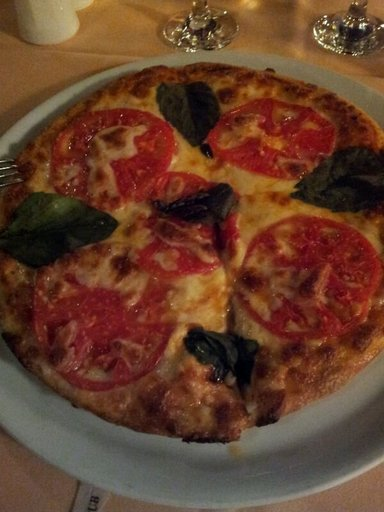

In [ ]:
# Visualize an image
import random
from PIL import Image

# Set seed
random.seed(777)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick up random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img= Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 383.5, 511.5, -0.5)

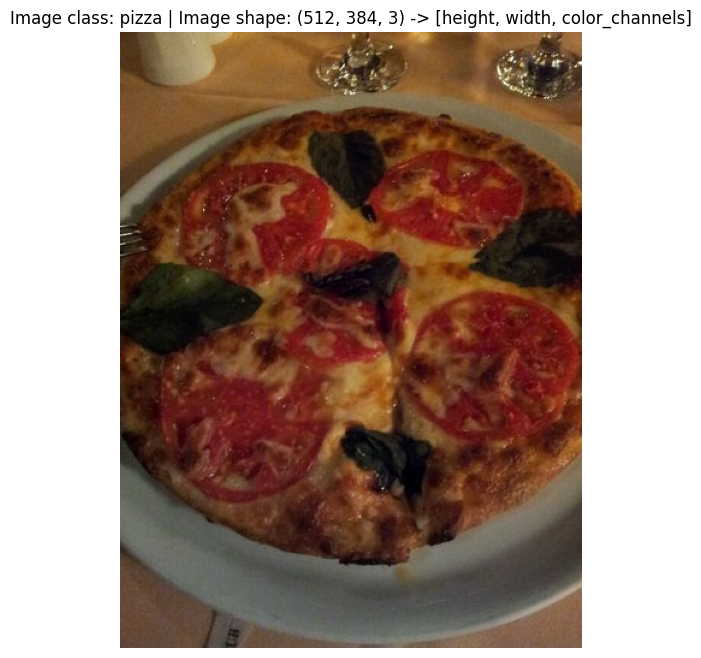

In [ ]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the images into an array
image_array = np.array(img)

# Plot the image with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(image_array)
plt.title(f"Image class: {image_class} | Image shape: {image_array.shape} -> [height, width, color_channels]")
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [ ]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
# Write transform for turning images into tensors
image_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64, 64)),

    # Horizontally flip the images
    transforms.RandomHorizontalFlip(p = 0.5),
    # Turn the image into a torch tensor
    transforms.ToTensor()
])

In [ ]:
image_transform(img).shape

torch.Size([3, 64, 64])

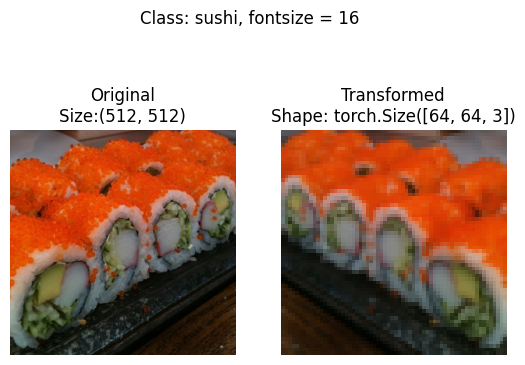

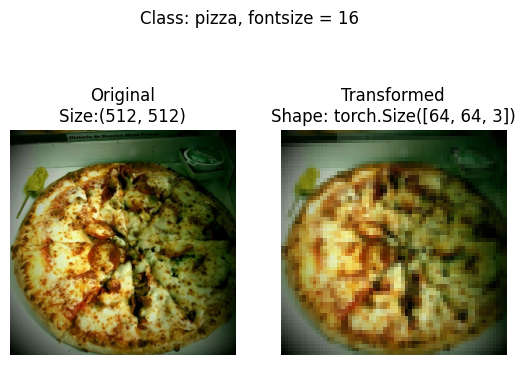

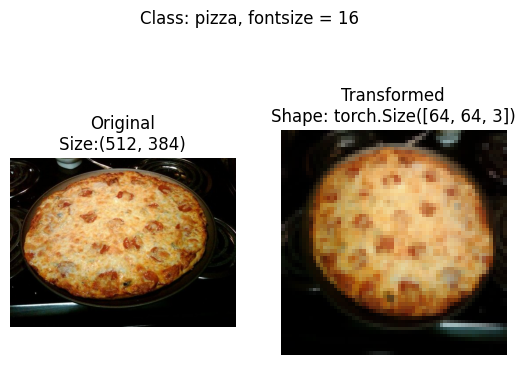

In [ ]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize:{f.size}")
      ax[0].axis("off")

      # Transform and plot target image
      transformed_image= transform(f).permute(1, 2, 0) # change the shape for matplotlib (HWC)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}, fontsize = 16")
plot_transformed_images(image_paths= image_path_list,
                        transform= image_transform,
                        n=3,
                        seed=777)

### Load image data using `ImageFolder`

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root= train_dir,
                                  transform= image_transform,
                                  target_transform= None)

test_data= datasets.ImageFolder(root= test_dir,
                                transform= image_transform)

train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE= 1
NUM_WORKERS = 1
train_dataloader= DataLoader(dataset= train_data,
                             batch_size= BATCH_SIZE,
                             num_workers= NUM_WORKERS,
                             shuffle= True)
test_dataloader= DataLoader(dataset= test_data,
                            batch_size= BATCH_SIZE,
                            num_workers= NUM_WORKERS,
                            shuffle= False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d4104dee170>,
 <torch.utils.data.dataloader.DataLoader at 0x7d4104dee080>)

In [ ]:
# How many batches of images are in our data loaders?
int(len(train_data)/BATCH_SIZE), int(len(test_data)/BATCH_SIZE)

(225, 75)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [ ]:

class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1= nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 0),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2,
                     stride= 2),
    )
    self.conv_block_2= nn.Sequential(
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 0),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2,
                     stride= 2),
    )
    self.classifier= nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units*13*13,
                  out_features= output_shape)
    )
  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [ ]:
len(class_names)

3

In [ ]:
torch.manual_seed(777)
model_0= TinyVGG(input_shape= 3,
                 hidden_units= 10,
                 output_shape= len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred= model_0(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()


    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class= torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc +=(y_pred_class ==y).sum().item()/ len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss= train_loss/ len(dataloader)
  train_acc= train_acc/ len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits= model(X)


      # 2. Calculuate and accumulate loss
      loss= loss_fn(test_pred_logits, y)
      test_loss +=loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels= test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels ==y). sum().item()/ len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss= test_loss / len(dataloader)
  test_acc= test_acc/ len(dataloader)
  return test_loss, test_acc


In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [ ]:
# Train for 5 epochs
torch.manual_seed(777)
torch.cuda.manual_seed(777)
num_epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model_0.parameters(),
                             lr=0.001)
model_0_5_epochs = train(model= model_0,
                         train_dataloader= train_dataloader,
                         test_dataloader= test_dataloader,
                         optimizer= optimizer,
                         loss_fn= loss_fn,
                         epochs= num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.3778 | test_loss: 1.0938 | test_acc: 0.4267
Epoch: 2 | train_loss: 1.0541 | train_acc: 0.4356 | test_loss: 1.1209 | test_acc: 0.3600
Epoch: 3 | train_loss: 0.9712 | train_acc: 0.5067 | test_loss: 0.9860 | test_acc: 0.4933
Epoch: 4 | train_loss: 0.9187 | train_acc: 0.5511 | test_loss: 1.0336 | test_acc: 0.4267
Epoch: 5 | train_loss: 0.9077 | train_acc: 0.5867 | test_loss: 0.9573 | test_acc: 0.5733


In [ ]:
# Train for 20 epochs
torch.manual_seed(777)
torch.cuda.manual_seed(777)
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr=0.001)

model_0_20_epochs = train(model= model_0,
                          train_dataloader= train_dataloader,
                          test_dataloader= test_dataloader,
                          optimizer= optimizer,
                          loss_fn= loss_fn,
                          epochs= num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8783 | train_acc: 0.6000 | test_loss: 1.0005 | test_acc: 0.4533
Epoch: 2 | train_loss: 0.8453 | train_acc: 0.6133 | test_loss: 1.0269 | test_acc: 0.4667
Epoch: 3 | train_loss: 0.7894 | train_acc: 0.6533 | test_loss: 1.0134 | test_acc: 0.4667
Epoch: 4 | train_loss: 0.7802 | train_acc: 0.7067 | test_loss: 1.0677 | test_acc: 0.4533
Epoch: 5 | train_loss: 0.7223 | train_acc: 0.6756 | test_loss: 1.0325 | test_acc: 0.4667
Epoch: 6 | train_loss: 0.7447 | train_acc: 0.7111 | test_loss: 1.0510 | test_acc: 0.4933
Epoch: 7 | train_loss: 0.6450 | train_acc: 0.7511 | test_loss: 1.0615 | test_acc: 0.4667
Epoch: 8 | train_loss: 0.6419 | train_acc: 0.7378 | test_loss: 1.1541 | test_acc: 0.4667
Epoch: 9 | train_loss: 0.6091 | train_acc: 0.7422 | test_loss: 1.1232 | test_acc: 0.5067
Epoch: 10 | train_loss: 0.5581 | train_acc: 0.7511 | test_loss: 1.2582 | test_acc: 0.5200
Epoch: 11 | train_loss: 0.5516 | train_acc: 0.7956 | test_loss: 1.1213 | test_acc: 0.5467
Epoch: 12 | train_l

In [ ]:
# Train for 50 epochs
torch.manual_seed(777)
torch.cuda.manual_seed(777)
num_epochs = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model_0.parameters(),
                             lr=0.001)

model_0_50_epochs= train(model= model_0,
                         train_dataloader= train_dataloader,
                         test_dataloader= test_dataloader,
                         optimizer= optimizer,
                         loss_fn= loss_fn,
                         epochs= num_epochs)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2601 | train_acc: 0.8889 | test_loss: 2.5399 | test_acc: 0.5200
Epoch: 2 | train_loss: 0.2230 | train_acc: 0.9156 | test_loss: 2.2196 | test_acc: 0.6133
Epoch: 3 | train_loss: 0.1879 | train_acc: 0.9422 | test_loss: 2.7120 | test_acc: 0.5200
Epoch: 4 | train_loss: 0.2092 | train_acc: 0.9289 | test_loss: 2.5411 | test_acc: 0.5333
Epoch: 5 | train_loss: 0.1648 | train_acc: 0.9422 | test_loss: 2.2648 | test_acc: 0.5600
Epoch: 6 | train_loss: 0.1991 | train_acc: 0.9156 | test_loss: 2.3771 | test_acc: 0.5067
Epoch: 7 | train_loss: 0.1018 | train_acc: 0.9644 | test_loss: 2.6493 | test_acc: 0.5333
Epoch: 8 | train_loss: 0.0731 | train_acc: 0.9867 | test_loss: 2.9770 | test_acc: 0.5600
Epoch: 9 | train_loss: 0.1365 | train_acc: 0.9422 | test_loss: 3.3806 | test_acc: 0.5600
Epoch: 10 | train_loss: 0.1280 | train_acc: 0.9511 | test_loss: 3.1908 | test_acc: 0.5333
Epoch: 11 | train_loss: 0.0795 | train_acc: 0.9733 | test_loss: 3.1791 | test_acc: 0.5467
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(777)
torch.cuda.manual_seed(777)
model_1 = TinyVGG(input_shape= 3,
                  hidden_units = 20,
                  output_shape= len(class_names)).to(device)
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model_1.parameters(),
                            lr= 0.001)
model_1_20_epochs= train(model= model_1,
                         train_dataloader= train_dataloader,
                         test_dataloader= test_dataloader,
                         optimizer= optimizer,
                         loss_fn= loss_fn,
                         epochs= num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 1.1025 | test_acc: 0.2533
Epoch: 2 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 1.1024 | test_acc: 0.2533
Epoch: 3 | train_loss: 0.0006 | train_acc: 1.0000 | test_loss: 1.1025 | test_acc: 0.2533
Epoch: 4 | train_loss: 0.0006 | train_acc: 1.0000 | test_loss: 1.1025 | test_acc: 0.2533
Epoch: 5 | train_loss: 0.0006 | train_acc: 1.0000 | test_loss: 1.1025 | test_acc: 0.2533
Epoch: 6 | train_loss: 0.0006 | train_acc: 1.0000 | test_loss: 1.1025 | test_acc: 0.2533
Epoch: 7 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 1.1025 | test_acc: 0.2533
Epoch: 8 | train_loss: 0.0006 | train_acc: 1.0000 | test_loss: 1.1026 | test_acc: 0.2533
Epoch: 9 | train_loss: 0.0006 | train_acc: 1.0000 | test_loss: 1.1026 | test_acc: 0.2533
Epoch: 10 | train_loss: 0.0007 | train_acc: 1.0000 | test_loss: 1.1025 | test_acc: 0.2533
Epoch: 11 | train_loss: 0.0006 | train_acc: 1.0000 | test_loss: 1.1025 | test_acc: 0.2533
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [ ]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.


Excellent, we now have double the training and testing images...

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
BATCH_SIZE = 1
train_data_20_percent = datasets.ImageFolder(root= train_data_20_percent_path,
                                  transform= simple_transform,
                                  target_transform= None)

test_data_20_percent = datasets.ImageFolder(root= train_data_20_percent_path,
                                 transform= simple_transform)

# Create dataloaders
train_dataloader_20_percent= DataLoader(dataset= train_data,
                             batch_size= BATCH_SIZE,
                             num_workers= 1,
                             shuffle= True)

test_dataloader_20_percent= DataLoader(dataset= test_data,
                            batch_size= BATCH_SIZE,
                            num_workers= 1,
                            shuffle= False)

In [ ]:
# Train a model with increased amount of data
torch.manual_seed(777)
torch.cuda.manual_seed(777)
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model_0.parameters(),
                            lr= 0.001)
model_0_20_percent = train(model= model_0,
                           train_dataloader= train_dataloader_20_percent,
                           test_dataloader= test_dataloader_20_percent,
                           optimizer= optimizer,
                           loss_fn= loss_fn,
                           epochs= num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0482 | train_acc: 0.9778 | test_loss: 6.2445 | test_acc: 0.5600
Epoch: 2 | train_loss: 0.0058 | train_acc: 1.0000 | test_loss: 5.2657 | test_acc: 0.5600
Epoch: 3 | train_loss: 0.0013 | train_acc: 1.0000 | test_loss: 5.3736 | test_acc: 0.5733
Epoch: 4 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 5.2627 | test_acc: 0.5867
Epoch: 5 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 4.7811 | test_acc: 0.6000
Epoch: 6 | train_loss: 0.0003 | train_acc: 1.0000 | test_loss: 5.3438 | test_acc: 0.5733
Epoch: 7 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 5.0689 | test_acc: 0.5600
Epoch: 8 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 4.9318 | test_acc: 0.6267
Epoch: 9 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 5.2200 | test_acc: 0.5733
Epoch: 10 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 5.6645 | test_acc: 0.5733
Epoch: 11 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 4.8577 | test_acc: 0.6000
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Traget dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Traget dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Could not find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

#### Create a custom `Dataset` to replicate `ImageFolder`

In [ ]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attribute
    # Get all the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)
  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
      "Opens an image via a path and returns it."
      image_path = self.paths[index]
      return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)
  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

  # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [ ]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size= (64, 64)),
    transforms.ToTensor()
])

In [ ]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform= train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform= test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7d41d90e7100>,
 <__main__.ImageFolderCustom at 0x7d41041b6a10>)

####  Turn custom loaded images into Dataloaders

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE =1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset= train_data_custom,
                                     batch_size= BATCH_SIZE,
                                     num_workers= NUM_WORKERS,
                                     shuffle= True)

test_dataloader_custom= DataLoader(dataset= test_data_custom,
                                    batch_size= BATCH_SIZE,
                                    num_workers= NUM_WORKERS,
                                    shuffle= False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7d4120d17c10>,
 <torch.utils.data.dataloader.DataLoader at 0x7d4120d17fa0>)

In [ ]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

In [ ]:
# Train a model with increased amount of data
torch.manual_seed(777)
torch.cuda.manual_seed(777)
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model_0.parameters(),
                            lr= 0.001)
model_0_custom_data = train(model= model_0,
                           train_dataloader= train_dataloader_custom,
                           test_dataloader= test_dataloader_custom,
                           optimizer= optimizer,
                           loss_fn= loss_fn,
                           epochs= num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1046 | train_acc: 0.9778 | test_loss: 7.6680 | test_acc: 0.5733
Epoch: 2 | train_loss: 0.0400 | train_acc: 0.9956 | test_loss: 7.5213 | test_acc: 0.5867
Epoch: 3 | train_loss: 0.0279 | train_acc: 0.9867 | test_loss: 7.5573 | test_acc: 0.5733
Epoch: 4 | train_loss: 0.0017 | train_acc: 1.0000 | test_loss: 7.3657 | test_acc: 0.5867
Epoch: 5 | train_loss: 0.2653 | train_acc: 0.9600 | test_loss: 6.7403 | test_acc: 0.6000
Epoch: 6 | train_loss: 0.0279 | train_acc: 0.9867 | test_loss: 7.0547 | test_acc: 0.5733
Epoch: 7 | train_loss: 0.0041 | train_acc: 1.0000 | test_loss: 6.9919 | test_acc: 0.6000
Epoch: 8 | train_loss: 0.0068 | train_acc: 1.0000 | test_loss: 7.0592 | test_acc: 0.5600
Epoch: 9 | train_loss: 0.0023 | train_acc: 1.0000 | test_loss: 6.7022 | test_acc: 0.5600
Epoch: 10 | train_loss: 0.0037 | train_acc: 1.0000 | test_loss: 6.5891 | test_acc: 0.6133
Epoch: 11 | train_loss: 0.0003 | train_acc: 1.0000 | test_loss: 6.6070 | test_acc: 0.6000
Epoch: 12 | train_l